Loaded 100 cases from QUBO data.
Loaded 100 cases from HUBO data.


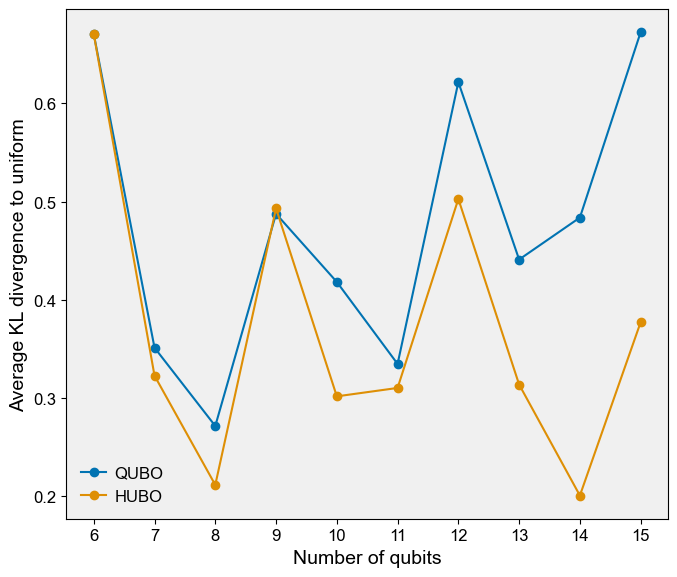

In [3]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import pandas as pd

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

def calculate_percentage_allocation(allocation):
    """Convert raw allocations to percentage allocations."""
    total = sum(allocation.values())
    if total == 0:
        return {asset: 0 for asset in allocation}
    return {asset: value / total * 100 for asset, value in allocation.items()}

def calculate_uniform_allocation(assets):
    """Calculate uniform allocation percentages for given assets."""
    num_assets = len(assets)
    return {asset: 100 / num_assets for asset in assets}

def calculate_entropy(allocation_percentages):
    """
    Calculate the entropy of an allocation to measure how far it is from uniform.
    Higher entropy means more uniform distribution (closer to equal weights).
    Lower entropy means more concentrated allocation.
    """
    # Convert percentage values to probabilities (divide by 100)
    probabilities = [p/100 for p in allocation_percentages.values()]
    # Filter out any zeros to avoid log(0) issues
    probabilities = [p for p in probabilities if p > 0]
    if not probabilities:
        return 0
    # Calculate entropy
    return entropy(probabilities, base=2)

def calculate_kl_divergence(p_allocation, q_allocation):
    """
    Calculate KL divergence between two allocations.
    p_allocation is the allocation being compared
    q_allocation is the reference allocation (usually uniform)
    """
    # Get common assets
    assets = set(p_allocation.keys()) | set(q_allocation.keys())
    
    # Ensure all assets are in both allocations (with 0 if missing)
    p = np.array([p_allocation.get(asset, 0)/100 for asset in assets])
    q = np.array([q_allocation.get(asset, 0)/100 for asset in assets])
    
    # Avoid division by zero by adding a small epsilon to zeros
    epsilon = 1e-10
    p = np.where(p == 0, epsilon, p)
    q = np.where(q == 0, epsilon, q)
    
    # Normalize to ensure they sum to 1
    p = p / np.sum(p)
    q = q / np.sum(q)
    
    # Calculate KL divergence
    return np.sum(p * np.log(p / q))

def visualize_allocations(allocations, uniform_allocation, metrics, save_path=None):
    """Visualize allocations and their distance from uniform allocation."""
    n = len(allocations)
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Set up the bar positions
    bar_width = 0.8 / (n + 1)
    index = np.arange(len(list(allocations.values())[0].keys()))
    
    # Plot each allocation
    for i, (name, alloc) in enumerate(allocations.items()):
        assets = list(alloc.keys())
        values = [alloc[asset] for asset in assets]
        ax.bar(index + i * bar_width, values, bar_width, label=f'{name} (Entropy: {metrics[name]["entropy"]:.3f})')
    
    # Plot uniform allocation
    assets = list(uniform_allocation.keys())
    values = [uniform_allocation[asset] for asset in assets]
    ax.bar(index + n * bar_width, values, bar_width, label=f'Uniform (Entropy: {metrics["Uniform"]["entropy"]:.3f})')
    
    # Add labels and legend
    ax.set_xlabel('Assets')
    ax.set_ylabel('Percentage Allocation (%)')
    ax.set_title('Portfolio Allocation Comparison')
    ax.set_xticks(index + bar_width * n / 2)
    ax.set_xticklabels(assets)
    ax.legend()
    
    # Add a table with metrics
    table_data = []
    for name in list(allocations.keys()) + ["Uniform"]:
        table_data.append([
            name,
            f"{metrics[name]['entropy']:.3f}",
            f"{metrics[name]['kl_div_to_uniform']:.3f}"
        ])
    
    plt.table(
        cellText=table_data,
        colLabels=["Allocation", "Entropy", "KL Divergence to Uniform"],
        loc='bottom',
        bbox=[0.0, -0.35, 1.0, 0.2]
    )
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.35)
    
    if save_path:
        plt.savefig(save_path)
    
    return fig, ax

# Main code
data = {}
data2 = {}

# Get file names like portfolio_optimization_results_batch_ from the parent directory
try:
    files = [file for file in os.listdir("../cmaes_qubo_mean_variance_results/") if "portfolio_optimization_results_batch_" in file]
    for file in files:
        data.update(load_json("../cmaes_qubo_mean_variance_results/" + file))
    
    print(f"Loaded {len(data)} cases from QUBO data.")
    
    files2 = [file for file in os.listdir("../cmaes_hubo_results/") if "portfolio_optimization_results_batch_" in file]
    for file in files2:
        data2.update(load_json("../cmaes_hubo_results/" + file))
    
    print(f"Loaded {len(data2)} cases from HUBO data.")
except FileNotFoundError:
    print("File directories not found. Using example data instead.")
    # Example data if directories not found
    data = {"example1": {"exact_solution": {"allocation": {"CAT": 3, "V": 4}}}}
    data2 = {"example1": {"exact_solution": {"allocation": {"CAT": 7, "V": 0}}}}

# Process for a fixed number of qubits or use example data
allocations = {}

for fixed_q in range(6, 16):
    cases = [i for i in data if data[i]['hyperparams']['n_qubits'] == fixed_q]
    #print(f"Found {len(cases)} cases with {fixed_q} qubits in QUBO data.")
    
    cases2 = [i for i in data2 if data2[i]['hyperparams']['n_qubits'] == fixed_q]
    #print(f"Found {len(cases2)} cases with {fixed_q} qubits in HUBO data.")
    
    # Get allocations from both datasets
    allocations[fixed_q] = {}
    
    if cases and cases2:
        # Select a case that exists in both datasets
        common_cases = set(cases).intersection(set(cases2))
        #print(f"Found {len(common_cases)} common cases.")
        for case_id in common_cases:
            
            allocation1 = data[case_id]['exact_solution'].get('optimized_portfolio', {})
            allocation2 = data2[case_id]['exact_solution'].get('optimized_portfolio', {})
            if type(allocation1) == list:
                allocation1 = allocation1[0]
            if type(allocation2) == list:
                allocation2 = allocation2[0]

            #print(f"Allocations for case {case_id}:")
            #print(f"QUBO: {allocation1}")
            #print(f"HUBO: {allocation2}")
            
            allocations[fixed_q][case_id] = {
                "QUBO": calculate_percentage_allocation(allocation1),
                "HUBO": calculate_percentage_allocation(allocation2)
            }

# Compute entropies and KL divergences for all qubits and cases in the allocations dictionary
metrics = {}

for qubit, cases in allocations.items():
    if isinstance(cases, dict):  # Ensure we are processing cases for a specific qubit
        metrics[qubit] = {}
        for case_id, allocs in cases.items():
            metrics[qubit][case_id] = {}
            for name, alloc in allocs.items():
                entropy_value = calculate_entropy(alloc)
                uniform_allocation = calculate_uniform_allocation(alloc)
                kl_div = calculate_kl_divergence(alloc, uniform_allocation)
                metrics[qubit][case_id][name] = {
                    "entropy": entropy_value,
                    "kl_div_to_uniform": kl_div,
                    "uniform_allocation": uniform_allocation
                }

# Compute average entropy and KL divergence values over the different cases for each qubit
average_metrics = {}

for qubit, cases in metrics.items():
    total_entropy_qubo = 0
    total_entropy_hubo = 0
    total_kl_qubo = 0
    total_kl_hubo = 0
    num_cases = len(cases)
    
    for case_id, alloc_metrics in cases.items():
        total_entropy_qubo += alloc_metrics["QUBO"]["entropy"]
        total_entropy_hubo += alloc_metrics["HUBO"]["entropy"]
        total_kl_qubo += alloc_metrics["QUBO"]["kl_div_to_uniform"]
        total_kl_hubo += alloc_metrics["HUBO"]["kl_div_to_uniform"]
    
    average_metrics[qubit] = {
        "QUBO": {
            "average_entropy": total_entropy_qubo / num_cases if num_cases > 0 else 0,
            "average_kl_div_to_uniform": total_kl_qubo / num_cases if num_cases > 0 else 0
        },
        "HUBO": {
            "average_entropy": total_entropy_hubo / num_cases if num_cases > 0 else 0,
            "average_kl_div_to_uniform": total_kl_hubo / num_cases if num_cases > 0 else 0
        }
    }

# Print the average metrics
#print("\nAverage Entropies and KL Divergences:")
#for qubit, avg_metrics in average_metrics.items():
#    print(f"\nQubits: {qubit}")
#    print(f"  QUBO: Average Entropy = {avg_metrics['QUBO']['average_entropy']:.3f}, "
#          f"Average KL Divergence to Uniform = {avg_metrics['QUBO']['average_kl_div_to_uniform']:.3f}")
#    print(f"  HUBO: Average Entropy = {avg_metrics['HUBO']['average_entropy']:.3f}, "
#          f"Average KL Divergence to Uniform = {avg_metrics['HUBO']['average_kl_div_to_uniform']:.3f}")

# Visualize the average metrics
qubits = sorted(average_metrics.keys())
qubo_entropies = [average_metrics[q]["QUBO"]["average_entropy"] for q in qubits]
hubo_entropies = [average_metrics[q]["HUBO"]["average_entropy"] for q in qubits]
qubo_kl_divs = [average_metrics[q]["QUBO"]["average_kl_div_to_uniform"] for q in qubits]
hubo_kl_divs = [average_metrics[q]["HUBO"]["average_kl_div_to_uniform"] for q in qubits]

# Set publication-quality parameters
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 14,
    'axes.linewidth': 0.8,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'legend.frameon': False,
    'legend.handlelength': 1.5,
    'legend.handletextpad': 0.5
})

# Create figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Set smoke gray background for plotting area
ax.set_facecolor('#f0f0f0')  # Light smoke gray

# Define a professional color palette (colorblind-friendly)
colors = {'qubo': '#0173B2', 'hubo': '#DE8F05'}

# Plot average KL divergence
ax.plot(qubits, qubo_kl_divs, label="QUBO", marker="o", color=colors['qubo'], linewidth=1.5)
ax.plot(qubits, hubo_kl_divs, label="HUBO", marker="o", color=colors['hubo'], linewidth=1.5)
# Make all values on x-axis visible
ax.set_xticks(qubits)

# Set labels and title
ax.set_xlabel("Number of qubits")
ax.set_ylabel("Average KL divergence to uniform")
#ax.set_title("Average KL Divergence vs Number of Qubits")

# Add legend
ax.legend()

# Adjust layout for better appearance
plt.tight_layout()

# Display the plot
plt.savefig("average_kl_divergence.png")
